In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import re
import os

%matplotlib inline

## Loading S8 Data 

In [2]:
def s8_load_data(path, file_, PLOT = True):
    """
    Pre-processing and prepares the accelerometer data from 
    the S8/S82 devices using the Gravity app for analysis.
    
    Parameters
    ----------
    path: string
        file path
        
    file_: string
        file name
        
    PLOT: boolean
        plot accelerometer data
        
    Returns
    -------
    sleep_df: pandas.DataFrame
        accelerometer data with additional columns
        
    total_recording_time: datetime object
        total recording time
        
    start: datetime object
        recording start time
        
    end: datetime object
        recording end time
    """
    
    name, date, time, night = [i for i in re.split('(\d+)', file_) if i not in ['_', '.csv']]
    startdatetime = dt.datetime.strptime(date + '-' + time, "%Y%m%d-%H%M")
    dt_fmt = lambda d: dt.datetime(d.year, d.month, d.day, d.hour, d.minute)
    
    sleep_df = pd.read_csv(path + file_, header = None, names = ['x', 'y', 'z', 'ns'])
    sleep_df['ns_readable_time'] = pd.to_timedelta(sleep_df.ns, unit = 'ns')
    sleep_df['elapsed_time'] = sleep_df['ns_readable_time'].apply(lambda x: x - sleep_df.ns_readable_time[0])
    sleep_df['actual_timestamp'] = sleep_df['elapsed_time'] + startdatetime
    sleep_df.set_index(['actual_timestamp'], inplace = True)
    
    start = sleep_df.index[0]
    end = sleep_df.index[-1]
    total_recording_time = end - start

    if PLOT:
        ax = sleep_df[['x', 'y', 'z']].plot(kind = 'line', use_index = True, color = list('bgr')
                                        , figsize = (17, 5), title = name + ' - Day ' + night)
        ax.legend(loc = 1 , bbox_to_anchor = (1, 1.15), ncol = 3)
        ax.xaxis.grid(True)
    
    return sleep_df, total_recording_time , start, end

## Sazonov's Algorithm 

Linear Combination and Logistic Regression Method

In [3]:
def Zero_Crossing_Counts(arr):
    """
    Returns the number/counts of zero crossings
    """
    return len(np.where(np.diff(np.sign(arr)))[0])

In [4]:
def Sazonov_Scoring(arr, thres = 0.7):
    """
    Returns the PS (Probability of Sleep) as computed using Sazonov's Model.
    
    Paramaters
    ----------
    arr: array
        axis data of length 9
    
    Returns
    -------
    op(dot_prod) > thres: Boolean
        If op(dot_prod) > thres then label epoch as Sleep.
        
    """
    coefs = [0.1945, 0.09746, 0.09975, 0.10194, 0.08917, 0.08108, 0.07494, 0.073, 0.10207][::-1]

    dot_prod = 1.99604 - np.dot(arr, coefs)
    op = lambda x: (1 + np.exp(-1 * x)) ** -1
    
    return op(dot_prod) > thres

In [5]:
def Set_Sazonov_Threshold(thres):
    """
    Returns a Sazonov Algorithm function with a different threshold.
    
    Parameters
    ----------
    thres: float, value ranges from 0 to 1.
    """
    def Sazonov_Scoring_Thres(arr, thres = thres):
    
        coefs = [0.1945, 0.09746, 0.09975, 0.10194, 0.08917, 0.08108, 0.07494, 0.073, 0.10207]
        coefs = coefs[::-1] # Reverse the list of coefficients

        dot_prod = 1.99604 - np.dot(arr, coefs)
        op = lambda x: (1 + np.exp(-1 * x)) ** -1

        return op(dot_prod) > thres
    
    return Sazonov_Scoring_Thres

In [6]:
def Sazonov_Algorithm(axis_data, timestamp, thres = None, how = 'max', PLOT = True, plot_title = ''):
    """
    axis_data and timestamp must be arrays.
    """
    data_df = pd.DataFrame(axis_data, index = timestamp, columns = ['d'])
    resampled = data_df[['d']].resample('1T', how = how)
    resampled.fillna(0, inplace = True)
    
    if thres != None:
        resampled['sleep_wake'] = pd.rolling_apply(resampled.d, window = 9, func = Set_Sazonov_Threshold(thres))
    else:
        resampled['sleep_wake'] = pd.rolling_apply(resampled.d, window = 9, func = Sazonov_Scoring)
    
    if PLOT:
        f, ax = plt.subplots(2, 1, sharex = True, figsize = (15, 5))
        ax[0].plot_date(data_df.index.values, data_df.d, '-', color = 'b')
        ax[0].xaxis.grid(True)
        ax[0].set_title(plot_title)
        
        ax[1].fill_between(resampled.index, resampled.sleep_wake, facecolor = 'yellow')
        ax[1].set_ylim(-0.05, 1.05)
    
    # label first 8 minutes as awake
    resampled.fillna(0, inplace = True)
    
    return resampled

## Reorientation Code 

In [9]:
def rotate_vector(x, y, z):
    """
    Accepts each principal directon of acceleration and calculates the angle
    between the passed data and the gravity vector (Y axis oriented to
    gravity). This angle is then used to rotate the original data to match
    the desired frame of reference.

    Inputs
    ------
    x : list or np.array
        Acceleration readings from the X axis
    y: list or np.array
        Acceleration readings from the Y axis
    z: list or np.array
        Acceleration readings from the Z axis

    Outputs
    -------
    rotated_data: np.array
        A [3 x len(x)] numpy matrix containing the original data rotated to
        fit the frame of reference.
    """
    avg_x = np.mean(x)
    avg_y = np.mean(y)
    avg_z = np.mean(z)

    initial_vector = [avg_x, avg_y, avg_z]
    desired_vector = [0, 9.8, 0]

    axis_vector = np.cross(initial_vector, desired_vector)
    normalized_axis_vector = axis_vector / ((axis_vector[0] ** 2
                                             + axis_vector[2] ** 2) ** (1 / 2))

    alpha = np.arccos(avg_y / (avg_x ** 2 + avg_y ** 2 + avg_z ** 2)
                      ** (1 / 2))

    q0 = np.cos(alpha / 2)
    q1 = np.sin(alpha / 2) * normalized_axis_vector[0]
    q2 = np.sin(alpha / 2) * normalized_axis_vector[1]
    q3 = np.sin(alpha / 2) * normalized_axis_vector[2]

    rotation_matrix = np.array([[1 - (2 * ((q2 ** 2) + (q3 ** 2))),
                                 2 * (q1 * q2 - q0 * q3),
                                 2 * (q0 * q2 + q1 * q3)],
                                [2 * (q1 * q2 + q0 * q3),
                                 1 - (2 * ((q1 ** 2) + (q3 ** 2))),
                                 2 * (q2 * q3 - q0 * q1)],
                                [2 * (q1 * q3 - q0 * q2),
                                 2 * (q0 * q1 + q2 * q3),
                                 1 - (2 * ((q1 ** 2) + (q2 ** 2)))]])
    rotated_data = np.dot(rotation_matrix, np.array([x, y, z]))

    return rotated_data


def reorient_axes(x, y, z, timestamps):
    """
    Accepts the principal directions of acceleration and the timestamps for
    each reading. Separates in to ten second buffers and measures the
    variance. If the variance is sufficiently low then the data is to rotated,
    otherwise it is left the same.

    Inputs
    ------
    x : list or np.array
        Acceleration readings from the X axis   y: list or np.array
    y: list or np.array
        Acceleration readings from the Y axis
    z: list or np.array
        Acceleration readings from the Z axis
    timestamps: list or np.array
        Timestamp array for acceleration readings

    Outputs
    -------
    reoritented_data: list
        A [3 x len(x)] list containing the original data all reoriented to the
        same frame of reference.
    """
    reoriented_data = [[], [], []]

    x_buffer = []
    y_buffer = []
    z_buffer = []
    buffer_timestamp = 0
    #buffers = []

    for i in xrange(len(x)):
        
        x_buffer.append(x[i])
        y_buffer.append(y[i])
        z_buffer.append(z[i])
        
        if not buffer_timestamp:
            buffer_timestamp = timestamps[i]
        
        time_diff_secs = (timestamps[i] - buffer_timestamp) * 1e-9
        #buffers.append([i, x_buffer[:], time_diff_secs])
        
        if time_diff_secs >= 10:
            
            if np.var(x_buffer) < 1:
                rotated = rotate_vector(x_buffer, y_buffer, z_buffer)
                reoriented_data[0].extend(list(rotated[0]))
                reoriented_data[1].extend(list(rotated[1]))
                reoriented_data[2].extend(list(rotated[2]))
            else:
                reoriented_data[0].extend(x_buffer)
                reoriented_data[1].extend(y_buffer)
                reoriented_data[2].extend(z_buffer)
                
            x_buffer = []
            y_buffer = []
            z_buffer = []
            buffer_timestamp = 0
            
    if len(x_buffer) > 0:
        
        if np.var(x_buffer) < 1:
            rotated = rotate_vector(x_buffer, y_buffer, z_buffer)
            reoriented_data[0].extend(list(rotated[0]))
            reoriented_data[1].extend(list(rotated[1]))
            reoriented_data[2].extend(list(rotated[2]))
            
        else:
            reoriented_data[0].extend(x_buffer)
            reoriented_data[1].extend(y_buffer)
            reoriented_data[2].extend(z_buffer)
            
    return reoriented_data #, buffers

## Apply Sazonov's Algorithm to S8/S82 data 

In [10]:
s8_path = "/Users/savvysherpaasiainc/Documents/P_Sleep Health/s8_data/"
files = filter(lambda f: f.endswith('.csv'), os.listdir(s8_path))

# exclude the files in list remove
remove = ['rdolor20151004_0518_0.csv', 'bmarquez20151018_0657_2.csv', 'jmondejar20151020_0159_0.csv']
for file_ in remove:
    files.remove(file_)

## Raw versus reoriented sleep prediction 

/Users/savvysherpaasiainc/.virtualenvs/data/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/savvysherpaasiainc/.virtualenvs/data/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=9).apply(args=<tuple>,func=<function>,kwargs=<dict>)


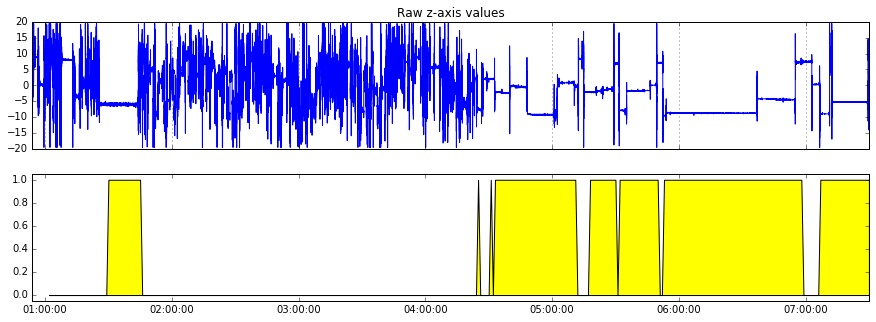

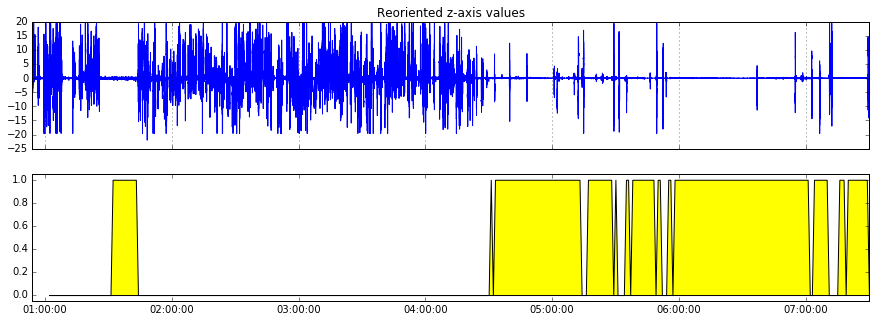

In [11]:
f = files[15]
person_df, total_rec_time, s, e = s8_load_data(s8_path, f, PLOT = False)
reOr = np.array(reorient_axes(person_df.x, person_df.y, person_df.z, person_df.ns))
person_df_reOr = pd.DataFrame(reOr.T, columns = list('xyz'), index = person_df.index)

threshold = 0.2
axis_timestamp = person_df.index.values

# Using raw accelerometer data, z-axis
raw_zAxis = Sazonov_Algorithm(person_df.z.values, axis_timestamp, thres = threshold, PLOT = True
                  , plot_title = 'Raw z-axis values')

# Using reoriented accelerometer data, z-axis
reor_zAxis = Sazonov_Algorithm(person_df_reOr.z.values, axis_timestamp, thres = threshold, PLOT = True
                  , plot_title = 'Reoriented z-axis values')

## Apply Sazonov's Algorithm to all accelerometer samples

Threshold Value = 0.2 <br>
Note: The cell below takes a while to run, about 45 minutes or so.

In [ ]:
threshold = 0.2
sleep_summary = []

for f in files:
    
    name, date, time, day = [i for i in re.split('(\d+)', f) if i not in ['_', '.csv']]
    
    person_df, total_rec_time, s, e = s8_load_data(s8_path, f, PLOT = False)
    reOr = np.array(reorient_axes(person_df.x, person_df.y, person_df.z, person_df.ns))
    person_df_reOr = pd.DataFrame(reOr.T, columns = list('xyz'), index = person_df.index)
    
    # Choose which axis to use, whether it is from the raw/reoriented data
    axis_values = person_df_reOr.z.values
    axis_timestamp = person_df_reOr.index.values
    
    Sazonov_PositionACC_reOr = Sazonov_Algorithm(axis_values, axis_timestamp, thres = threshold, PLOT = False)
    
    Sazonov_sleep_time_mins = Sazonov_PositionACC_reOr[Sazonov_PositionACC_reOr.sleep_wake == 1].count().sleep_wake

    sleep_summary.append([name, day, pd.to_timedelta(Sazonov_sleep_time_mins, unit = 'm')
                          , total_rec_time, s, e])
    print f
    
print 'DONE!'

In [ ]:
sleep_summary_cols = ['name', 'day', 'Sazonov_total_sleep_time', 'S8_total_recording_time'
                      , 'S8_starttime', 'S8_endtime']
Sazonov_Results = pd.DataFrame(sleep_summary, columns = sleep_summary_cols)
Sazonov_Results['day'] = Sazonov_Results.day.apply(int)
Sazonov_Results.head()

## Sleep Diary Data 

In [12]:
def WASO_minutes(waso_str):
    """
    Parameters
    ----------
    
    waso_str: string
        separator for WASO information - |
        
    Returns
    -------
    
    waso_min: float
        minutes awake after sleep onset 
    """
    if waso_str == '':
        t = 0.0
    else:
        t = sum([float(i.split('-')[1]) for i in waso_str.split('|')])
        
    return pd.to_timedelta(t, unit = 'm')

In [13]:
sleepDiary_path = "/Users/savvysherpaasiainc/Documents/P_Sleep Health/Sleep Diary Data - Cebu Research CSV.csv"
sleepDiary = pd.read_csv(sleepDiary_path, skiprows = 1)

# remove excluded rows
sleepDiary = sleepDiary[sleepDiary.night_count.notnull()]
sleepDiary.fillna('', inplace = True)
sleepDiary['on_bed'] = pd.to_datetime(sleepDiary.on_bed, format = '%m/%d/%Y %I:%M%p')
sleepDiary['off_bed'] = pd.to_datetime(sleepDiary.off_bed, format = '%m/%d/%Y %I:%M%p')

ToTime = lambda s: apply(lambda h, m: pd.to_timedelta(int(h), unit = 'h') + pd.to_timedelta(int(m), unit = 'm')
                         , s.split(':'))

sleepDiary['total_bed_time'] = sleepDiary.total_bed_time.apply(ToTime)
sleepDiary['WASO_minutes'] = sleepDiary.WASO.apply(WASO_minutes)
sleepDiary['total_sleep_time'] = sleepDiary['total_bed_time'] - sleepDiary['WASO_minutes']

##Merge Sleep Diary Data with Sleep/Wake detection results 

In [14]:
sleepAnalysis_res = pd.merge(Sazonov_Results, sleepDiary, on = ['name', 'day'])

In [15]:
cols_needed = ['name', 'day', 'Sazonov_total_sleep_time', 'S8_total_recording_time'
               , 'total_bed_time', 'WASO_minutes', 'total_sleep_time']
sleepAnalysis_res[cols_needed]

,name,day,Sazonov_total_sleep_time,S8_total_recording_time,total_bed_time,WASO_minutes,total_sleep_time
0,aabellera,1,05:50:00,06:58:01.190001,07:06:00,00:00:00,07:06:00
1,aabellera,2,05:34:00,06:57:41.200001,06:55:00,00:00:00,06:55:00
2,aabellera,3,03:59:00,05:46:47.900001,05:35:00,00:00:00,05:35:00
3,aquerouz,1,04:05:00,04:33:57.800000,04:40:00,00:00:00,04:40:00
4,aremirata,1,02:36:00,03:54:08.010000,04:52:00,00:00:00,04:52:00
5,aremirata,2,03:58:00,05:24:59.850001,06:00:00,00:00:00,06:00:00
6,avicente,1,04:26:00,04:45:39.190001,05:00:00,00:00:00,05:00:00
7,bmarquez,1,06:01:00,08:07:20.430001,08:15:00,00:10:00,08:05:00
8,bmarquez,3,03:28:00,05:00:02.940001,05:00:00,00:00:00,05:00:00
9,ccabiling,1,03:15:00,05:14:16.250001,05:12:00,00:12:00,05:00:00


Save result as CSV file